In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
#import data and define test and train datasets
test = pd.read_pickle('test.pkl')
train = pd.read_pickle('train.pkl')

selected_features1 = train.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = train.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = train.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_train = selected_features
y_train = train["firm"]

selected_features1 = test.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = test.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = test.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_test = selected_features
y_test = test["firm"]

In [3]:
#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [5]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [6]:
#view best parameters
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}

In [7]:
#create base model to compare to
base_model = RandomForestClassifier(n_estimators = 10, random_state = 41)
base_model.fit(X_train, y_train)
print(np.average(cross_val_score(base_model, X_train, y_train, cv=5)))
print(base_model.score(X_test, y_test))

0.8513071895424836
0.8772845953002611


In [8]:
#view best model scores from hyperparameter tuning
best_random = rf_random.best_estimator_
print(rf_random.best_score_)
print(rf_random.score(X_test, y_test))

0.8637254901960785
0.8864229765013055


In [9]:
#view classification
y_pred_test = best_random.predict(X_test)
result1 = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(result1)

Classification Report:
              precision    recall  f1-score   support

       Big 4       0.88      0.95      0.91       463
       Other       0.91      0.80      0.85       303

    accuracy                           0.89       766
   macro avg       0.89      0.87      0.88       766
weighted avg       0.89      0.89      0.88       766



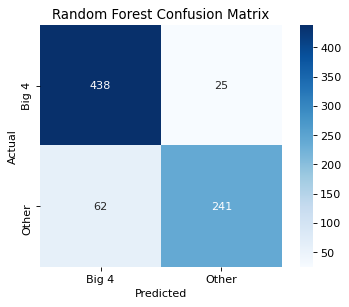

In [10]:
#view confussion matrix
rf_confusion = confusion_matrix(y_test, y_pred_test)
plt.figure(dpi=80)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Big 4', 'Other'],
           yticklabels=['Big 4', 'Other'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix');

In [14]:
#prepare and view feature importances
importance = best_random.feature_importances_
features = np.array(selected_features.columns)
sorted_importance = importance.argsort()[::-1]
features[sorted_importance]

array(['ev', 'revenueusd', 'ncfo_abs', 'marketcap', 'ebitdausd', 'assets',
       'cashnequsd', 'capex', 'equityusd', 'ncfcommon_abs',
       'netinccmnusd', 'ncff_abs', 'liabilities', 'debtusd', 'ncfi_abs',
       'ncfdebt_abs', 'industry_Banks - Regional', 'ncfbus_abs',
       'ncfdiv_abs', 'ncfinv_abs', 'exchange_NYSE',
       'industry_Biotechnology', 'exchange_OTC', 'ncfo_io', 'ncff_io',
       'ncfcommon_io', 'exchange_NASDAQ', 'ncfinv_io', 'ncfdiv_io',
       'ncfbus_io', 'ncfdebt_io', 'location_Texas; U.S.A',
       'location_California; U.S.A', 'location_Massachusetts; U.S.A',
       'exchange_NYSEMKT', 'ncfi_io', 'industry_Asset Management',
       'location_China', 'location_Florida; U.S.A',
       'location_New York; U.S.A', 'industry_Software - Application',
       'location_Pennsylvania; U.S.A', 'location_Oklahoma; U.S.A',
       'industry_Credit Services', 'industry_Oil & Gas E&P',
       'location_Illinois; U.S.A',
       'industry_Oil & Gas Refining & Marketing',
     

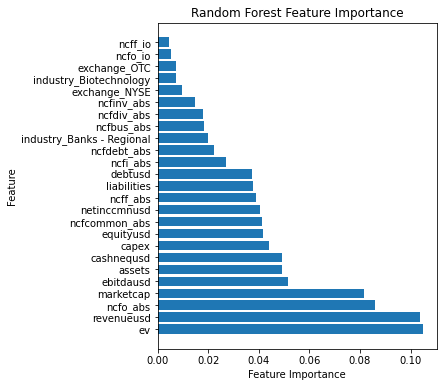

In [15]:
#visualize feature importances
fig, ax = plt.subplots(figsize=(5,6))

ax.barh(features[sorted_importance][:25], importance[sorted_importance][:25])
ax.set_title('Random Forest Feature Importance')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature');

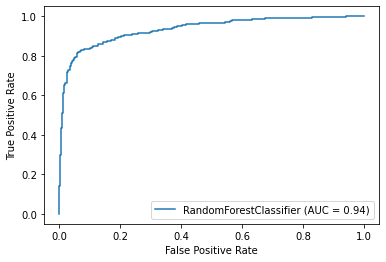

In [16]:
#view ROC curve
metrics.plot_roc_curve(best_random, X_test, y_test)
plt.show()

In [44]:
test['predict'] = y_pred_test
results_df = test[['name', 'firm_name', 'firm', 'predict', 'exchange', 'industry', 'location', 'scalemarketcap', 'scalerevenue']]
results_df.reset_index(inplace=True)
p_prob = pd.DataFrame(best_random.predict_proba(X_test), columns=['p_prob_1', 'p_prob_2'])
df = results_df.join(p_prob)
df['predict_bool'] = np.where(results_df.firm == results_df.predict, 0, 1)
df_incorrect = df[df.predict_bool == 1]
df_incorrect

,index,name,firm_name,firm,predict,exchange,industry,location,scalemarketcap,scalerevenue,p_prob_1,p_prob_2,predict_bool
5,2048,Liveperson Inc,"BDO USA, LLP",Other,Big 4,NASDAQ,Software - Application,New York; U.S.A,4 - Mid,3 - Small,0.803790,0.196210,1
8,2351,Newtek Business Services Corp,RSM US LLP,Other,Big 4,NASDAQ,Asset Management,Florida; U.S.A,3 - Small,2 - Micro,0.610698,0.389302,1
22,984,Diffusion Pharmaceuticals Inc,KPMG LLP,Big 4,Other,NASDAQ,Biotechnology,Virginia; U.S.A,2 - Micro,1 - Nano,0.147817,0.852183,1
28,1190,Energy Transfer LP,Grant Thornton LLP,Other,Big 4,NYSE,Oil & Gas Midstream,Texas; U.S.A,5 - Large,5 - Large,0.991985,0.008015,1
36,643,Ceco Environmental Corp,"BDO USA, LLP",Other,Big 4,NASDAQ,Pollution & Treatment Controls,Texas; U.S.A,3 - Small,3 - Small,0.536040,0.463960,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,3765,Intersect ENT Inc,Ernst & Young LLP,Big 4,Other,NASDAQ,Medical Devices,California; U.S.A,3 - Small,2 - Micro,0.497039,0.502961,1
746,708,Seacor Holdings Inc,Grant Thornton LLP,Other,Big 4,NYSE,Oil & Gas Equipment & Services,Florida; U.S.A,4 - Mid,4 - Mid,0.849098,0.150902,1
748,1361,Fox Factory Holding Corp,Grant Thornton LLP,Other,Big 4,NASDAQ,Recreational Vehicles,Georgia; U.S.A,4 - Mid,3 - Small,0.695656,0.304344,1
754,2312,National American University Holdings Inc,Deloitte & Touche LLP,Big 4,Other,OTC,Education & Training Services,South Dakota; U.S.A,2 - Micro,2 - Micro,0.084961,0.915039,1


In [96]:
#how confident is model predicting false positives
false_pos = df_incorrect.sort_values(by=['p_prob_2'])[df_incorrect.p_prob_1 >= .5]
false_pos
print(np.average(false_pos['p_prob_1']))
print(np.median(false_pos['p_prob_1']))

0.7333456627947368
0.729148549227806


<ipython-input-96-ff602f13d840>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  false_pos = df_incorrect.sort_values(by=['p_prob_2'])[df_incorrect.p_prob_1 >= .5]


In [89]:
result = false_pos.groupby(["firm_name"]).agg('count').reset_index().sort_values('index')

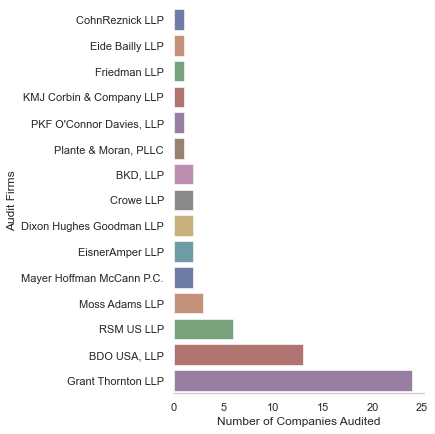

In [88]:
sns.set_style("whitegrid", {'axes.grid' : False})

g = sns.catplot(
    data=false_pos,
    y="firm_name", kind="count",
    ci="sd", palette="dark", alpha=.6, height=6,
    order=result['firm_name'])

g.despine(left=True)
g.set_axis_labels("Number of Companies Audited", "Audit Firms");

In [98]:
#how confident is model predicting false negatives
false_neg = df_incorrect.sort_values(by=['p_prob_2'])[df_incorrect.p_prob_1 <= .5]
false_neg
print(np.average(false_neg['p_prob_2']))
print(np.median(false_neg['p_prob_2']))

0.6787179446998255
0.6449135354880978


<ipython-input-98-7710108c00ee>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  false_pos = df_incorrect.sort_values(by=['p_prob_2'])[df_incorrect.p_prob_1 <= .5]


In [ ]:
filename = 'randomforest.pkl'
pickle.dump(best_random, open(filename, 'wb'))